# Imports

In [1]:
import json, requests, time
import torch
import numpy as np
import matplotlib.pyplot as plt

from diffusers import StableDiffusionXLPipeline
from transformers import BlipProcessor, BlipForConditionalGeneration
from sentence_transformers import SentenceTransformer

/workspace/COW_66/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Models load

In [2]:
## Stable Diffusion XL
STABLE_DIFF_PIPELINE = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
STABLE_DIFF_PIPELINE = STABLE_DIFF_PIPELINE.to("cuda")

## BLIP
BLIP_PROCCESOR = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
BLIP_MODEL = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

## MPNET embedding
MPNET = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

Loading pipeline components...: 100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


# Caption generation using Blip

In [3]:
def generate_caption(img):
    inputs = BLIP_PROCCESOR(img, return_tensors="pt")

    out = BLIP_MODEL.generate(**inputs)
    return BLIP_PROCCESOR.decode(out[0], skip_special_tokens=True)

# Sentence similarity with DistilBERT

In [4]:
with open('info.json', 'r') as f:
    info = json.load(f)
api_token = info['api_token']

In [5]:
API_URL = "https://api-inference.huggingface.co/models/sentence-transformers/msmarco-distilbert-base-tas-b"
headers = {"Authorization": f"Bearer {api_token}"}

def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

In [6]:
def sentence_similarity(input_sentence, sentences):
    data = query(
        {
            "inputs": {
                "source_sentence": input_sentence,
                "sentences": sentences
            }
        })
    
    return data

# Cosine similarity

In [14]:
def cosine_sim(a, b):
    return  np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

# Generating original batch of images

In [7]:
prompt = "a lecturer giving a speech about Generative AI"
images = STABLE_DIFF_PIPELINE(prompt=prompt, num_images_per_prompt=5,
                             output_type='pil').images

100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


# Calculate captions

In [8]:
captions = []
for i, img in enumerate(images):
    
    print("Processing image", i)
    caption = generate_caption(img)
    print("Generated caption:", caption)
    captions.append(caption)

Processing image 0


/workspace/COW_66/env/lib/python3.8/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated caption: a classroom with a man giving a presentation
Processing image 1
Generated caption: a robot standing in a classroom
Processing image 2
Generated caption: a man giving a presentation to a group of people
Processing image 3
Generated caption: a robot is sitting on a table
Processing image 4
Generated caption: a man in a suit


# Calculate similarities

## Using DistilBERT similarity

In [9]:
distil_similarities = dict()
while type(distil_similarities) == dict:
    distil_similarities = sentence_similarity(prompt, captions)
    if type(distil_similarities) == dict:
        print('Waiting for availability: ', distil_similarities['estimated_time'])
        time.sleep(distil_similarities['estimated_time'])

## Using cosine distance between text embeddings of MPNet

In [11]:
capt_em = MPNET.encode(captions)
prompt_em = MPNET.encode(prompt)

In [15]:
cos_similarities = []

for cap in capt_em:
    cos_similarities.append(cosine_sim(cap, prompt_em))

# Show all results

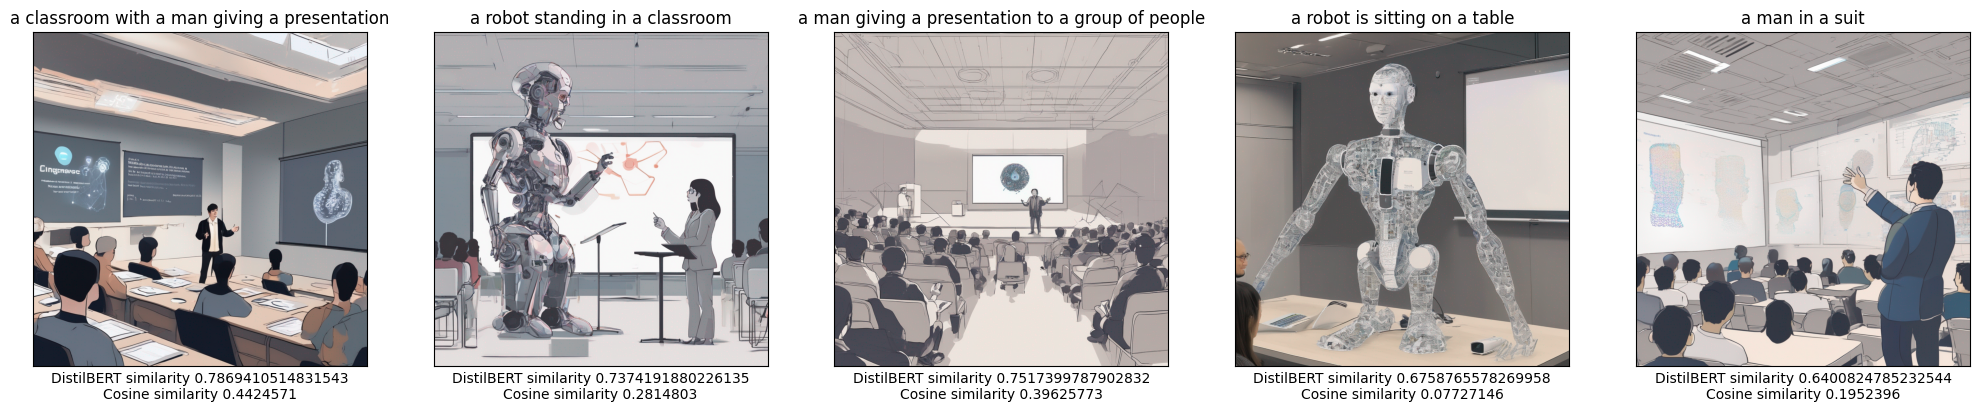

In [20]:
fig, ax = plt.subplots(1, len(captions), figsize=(5*len(captions), 5))
i=0

for img, caption, distil_similarity, cos_similarity in zip(images, captions, distil_similarities, cos_similarities):
    ax[i].imshow(img)
    ax[i].set_title(caption)
    ax[i].set_xlabel('DistilBERT similarity ' + str(distil_similarity) + '\nCosine similarity ' + str(cos_similarity))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
    i+=1
plt.show()